# Richards equation

In this tutorial we present how to solve a Richards equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,2)\times(0,3)$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, \psi)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:

$$
\psi(t,x,z)=
\left\{
\begin{array}{ll}
\begin{array}{l} 
-2+2.2 \frac{t}{\Delta t_D}, \text{ on } \Gamma_{D_1}, t\leq\Delta t_D\\
0.2, \text{ on } \Gamma_{D_1}, t>\Delta t_D\\
1-z, \text{ on } \Gamma_{D_2}
\end{array}
\end{array}
\right., \qquad \nu \cdot q = 0 \text{ on } \Gamma_N \qquad \psi(0,x,z) = 1-z \text{ on } \Omega$$
and
$$
\Gamma_{D_1} = \left\{ (x,z) \in \partial \Omega \:|\: x \in [0,1] \wedge z=3  \right\},\\
\Gamma_{D_2} = \left\{ (x,z) \in \partial \Omega \:|\: x = 2 \wedge z \in [0,1]  \right\},\\
\Gamma_{D} = \Gamma_{D_1} \cup \Gamma_{D_2},\\
\Gamma_{N} = \partial \Omega \setminus \Gamma_D
$$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

### Import and parameters

In [1]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
from scipy.sparse import linalg
import sympy as sp

import porepy as pp
import pygeon as pg

import time
from math import ceil, floor, log10, exp

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, "/workspaces/richards/")

from richards.model_params import Model_Data
from richards.matrix_computer import Matrix_Computer

from richards.solver import Solver
from richards.solver_params import Solver_Data, Solver_Enum

In [3]:
K = 50
N = 20
num_steps = 9

eps_psi_abs = 1e-6
eps_psi_rel = 1e-6

domain_tolerance = 1 / (10 * N)
beta_q   = 0
beta_psi = 0

output_directory = 'output_evolutionary'

In [4]:
rho = 1000
g = pp.GRAVITY_ACCELERATION

In [5]:
theta_s = 0.396
theta_r = 0.131

alpha = 0.423

n = 2.06
K_s = 4.96e-2

dt_D = 1/16
T    = 9/48

In [6]:
h_s = 0
theta_m = theta_s
m = 1 - 1/n
L = 3.501e-2

In [7]:
dt   = (T-0)/num_steps

In [8]:
model_data = Model_Data(theta_r=theta_r, theta_s=theta_s, alpha=alpha, n=n, K_s=K_s, T=T, num_steps=num_steps)

### $\theta$ and $k$, with their derivatives w.r.t. $\psi$

In [9]:
def quick_plot():
    psi_val = np.linspace(-2, 1, 100)

    theta_max = theta_s
    theta_min = theta_r

    _, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))

    ax1.plot(psi_val, model_data.theta(psi_val))
    ax1.plot(psi_val, theta_max * np.ones_like(psi_val), linestyle="--", color="red")
    ax1.plot(
        psi_val,
        theta_min * np.ones_like(psi_val),
        linestyle="--",
        color="green",
    )
    ax1.set_title("theta")

    ax2.plot(psi_val, model_data.hydraulic_conductivity_coefficient(psi_val))
    ax2.set_title("K")

    ax3.plot(psi_val, model_data.inverse_hydraulic_conductivity_coefficient(psi_val))
    ax3.set_title("K^-1")

    ax4.plot(psi_val, model_data.theta(psi_val, 1))
    ax4.set_title("d theta / d psi")

    ax5.plot(psi_val, model_data.hydraulic_conductivity_coefficient(psi_val, 1))
    ax5.set_title("d (K) / d psi")

    ax6.plot(psi_val, model_data.inverse_hydraulic_conductivity_coefficient(psi_val, 1))
    ax6.set_title("d (K^-1) / d psi")


    plt.show()

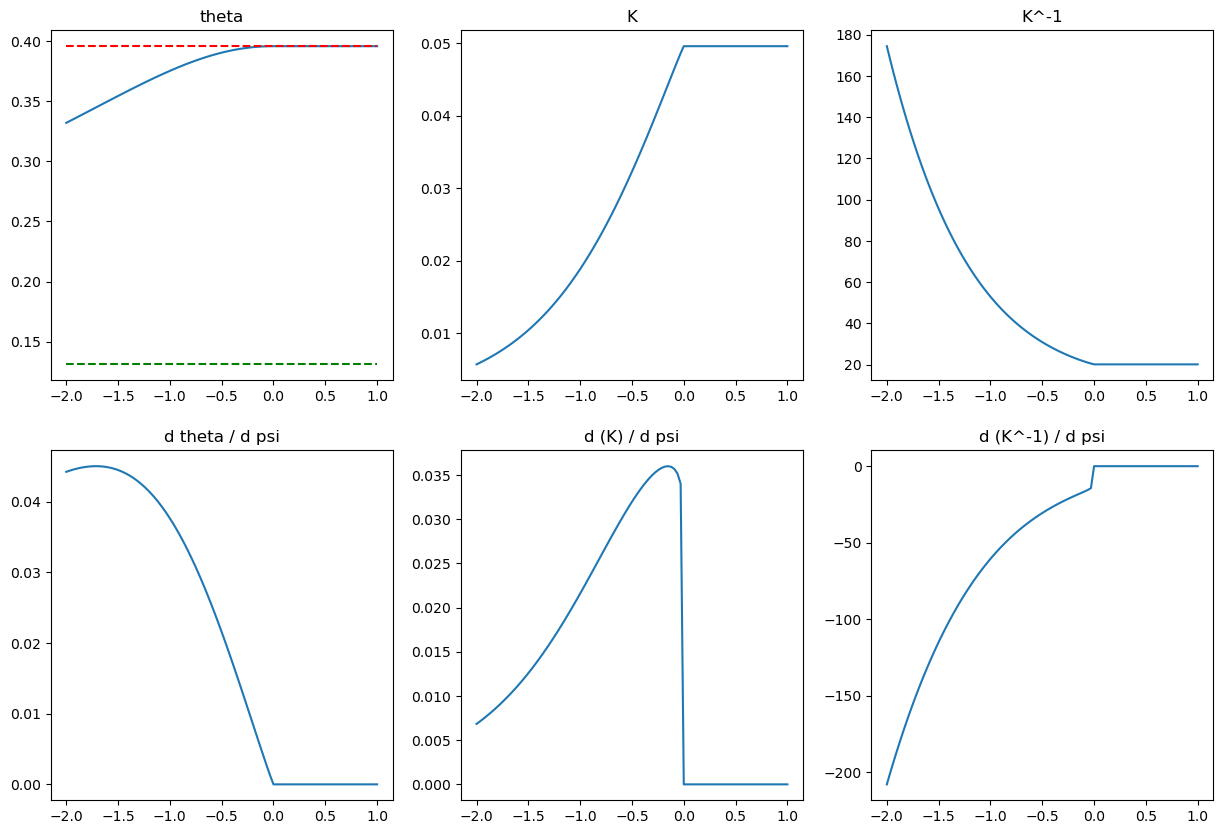

In [10]:
quick_plot()

### Domain preparation

In [11]:
subdomain = pp.StructuredTriangleGrid([2*N, 3*N], [2,3])
# convert the grid into a mixed-dimensional grid
mdg = pp.meshing.subdomains_to_mdg([subdomain])

In [12]:
key = "flow"

bc_value = []
bc_essential = []
initial_pressure = []

gravity = []

RT0 = pg.RT0(key)
P0  = pg.PwConstants(key)

In [13]:
def g_func(x, t): 
    return np.array([0, -1, -1])

In [14]:
def initial_pressure_func(x): 
    return 1-x[1]

In [15]:
for subdomain, data in mdg.subdomains(return_data=True):
    g_proj = RT0.interpolate(subdomain, lambda x: g_func(x,0))
    gravity.append(RT0.assemble_mass_matrix(subdomain) @ g_proj)
    
    initial_pressure.append(P0.interpolate(subdomain, initial_pressure_func))
        
    # with the following steps we identify the portions of the boundary
    # to impose the boundary conditions
    boundary_faces_indexes = subdomain.get_boundary_faces()

    gamma_d1 = np.logical_and(subdomain.face_centers[0, :] > 0-domain_tolerance, np.logical_and(subdomain.face_centers[0, :] < 1+domain_tolerance, subdomain.face_centers[1, :] > 3-domain_tolerance))
    gamma_d2 = np.logical_and(subdomain.face_centers[0, :] > 2-domain_tolerance, np.logical_and(subdomain.face_centers[1, :] > 0-domain_tolerance, subdomain.face_centers[1, :] < 1+domain_tolerance))

    gamma_d  = np.logical_or(gamma_d1, gamma_d2)
    
    gamma_n  = gamma_d.copy()
    gamma_n[boundary_faces_indexes] = np.logical_not(gamma_n[boundary_faces_indexes])
    

    pp.initialize_data(subdomain, data, key, {
        "second_order_tensor": pp.SecondOrderTensor(np.ones(subdomain.num_cells)),
    })
    
    def bc_gamma_d(x, t):
        if   x[0] > 2-domain_tolerance and x[1] > 0-domain_tolerance and x[1] < 1+domain_tolerance:
            res =  1 - x[1]
        elif x[1] > 3-domain_tolerance and x[0] > 0-domain_tolerance and x[0] < 1+domain_tolerance:
            res = min( 0.2, -2 + 2.2 * t / dt_D )
        else:
            res = 0
        
        return res

    bc_value.append(lambda t: - RT0.assemble_nat_bc(subdomain, lambda x: bc_gamma_d(x,t), gamma_d))

    essential_pressure_dofs = np.zeros(P0.ndof(subdomain), dtype=bool)
    bc_essential.append(np.hstack((gamma_n, essential_pressure_dofs)))

### Method

A quick recap:
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi) {q} + \nabla \psi = -\nabla z\\
\partial_t \theta (\psi) + \nabla \cdot {q} = 0
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
becames, with the time discretization:

$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
K^{-1}(\psi^{n+1}_k) {q^{n+1}_{k+1}} + \nabla \psi^{n+1}_{k+1} = -\nabla z\\
\frac{\partial \theta(\psi_k^{n+1})}{\partial \psi} \frac{\psi_{k+1}^{n+1}}{\Delta t} + \nabla \cdot {q^{n+1}} = \frac{\partial \theta(\psi_k^{n+1})}{\partial \psi} \frac{\psi_{k}^{n+1}}{\Delta t} + \frac{\theta (\psi^{n}) - \theta (\psi^{n+1}_k)}{\Delta t} 
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$

In [16]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [17]:
# assemble initial solution
cp = Matrix_Computer(mdg)
initial_solution = np.zeros(cp.dof_q[0] + cp.dof_psi[0])
initial_solution[-cp.dof_psi[0]:] += np.hstack(initial_pressure)

In [18]:
solver_data = Solver_Data(mdg=mdg, initial_solution=initial_solution, scheme=Solver_Enum.LSCHEME, 
                          bc_essential=lambda t: bc_essential, eps_psi_abs=eps_psi_abs, 
                          eps_psi_rel=eps_psi_rel, max_iterations_per_step=K,
                          output_directory=output_directory, L_Scheme_value=L, report_name='benchmark_problem')

solver_data.set_rhs_vector_q(lambda t: np.hstack(list(cond(t) for cond in bc_value)))
solver_data.set_rhs_function_q(g_func)

In [19]:
solver = Solver(model_data=model_data, solver_data=solver_data)

In [20]:
start = time.time()
solver.solve()
end = time.time()

print('')
print(end - start)

Time 0.02083
Iteration #001, error L2 relative psi:    0.0041085916
Iteration #002, error L2 relative psi:    0.0006550160
Iteration #003, error L2 relative psi:    0.0000563016
Iteration #004, error L2 relative psi:    0.0000014804
Iteration #005, error L2 relative psi:    0.0000002654

Time 0.04167
Iteration #001, error L2 relative psi:    0.0067668639
Iteration #002, error L2 relative psi:    0.0018252942
Iteration #003, error L2 relative psi:    0.0003603291
Iteration #004, error L2 relative psi:    0.0000335383
Iteration #005, error L2 relative psi:    0.0000123099
Iteration #006, error L2 relative psi:    0.0000015837
Iteration #007, error L2 relative psi:    0.0000004307

Time 0.0625
Iteration #001, error L2 relative psi:    0.0097346431
Iteration #002, error L2 relative psi:    0.0032600043
Iteration #003, error L2 relative psi:    0.0009107898
Iteration #004, error L2 relative psi:    0.0001541097
Iteration #005, error L2 relative psi:    0.0000579770
Iteration #006, error L2 